### **Unsupervised Learning**

**Data preparation**
- convert images into feature vectors (ensure normalization for normalization and preprocessing for consistency)

**Clustering**
- explore K-means and choose optimal number of clusters (K) using techniques like the elbow method or silhouette score
- evaluate performance and visualize clustering results for insights into data distribution and cluster relationships

**PCA**
- reduce dimensionality and select number of principal components based on variance ratio
- analyze contribution of each component and assess impact on data structure
- compare performance using original features vs. PCA-reduced features

**Integration with supervised learning**
- explore clustering and pca results and evaluate model learning performance

**Analyze Model Performance**
- plot loss and accuracy over epochs to visualize training progress and identify potential overfitting or underfitting.
- create a confusion matrix to examine how well the model distinguishes between classes.

In [57]:
# importing all necessary libraries
import glob
import warnings
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision 
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from PIL import Image
from typing import Dict, List, Tuple
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, accuracy_score, silhouette_score, classification_report)
from datasets_unsupervised import BrainTumorMRIDataset

In [2]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    NUM_CLASSES = 4
    EPOCHS = 16
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
    LR = 0.001
    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    
    # Define paths
    DATASET_PATH = './data/original/'
    TRAIN_PATH = './data/original//Training/'
    TEST_PATH = './data/original/Testing/'
    
# Mute warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [3]:
train_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{CFG.TEST_PATH}**/*.jpg")

In [4]:
def generate_labels(image_paths):
    return [(_.split('/')[-2:][0]).replace('-', '_') for _ in image_paths]

def build_df(image_paths, labels):
    df = pd.DataFrame({'image_path': image_paths, 'label': generate_labels(labels)})
    return df

def _load(image_path, as_tensor=True, target_size=(224,224)):
    # Read and decode an image file to a uint8 tensor
    image = Image.open(image_path)
    
    # Resize image to target size and convert to RGB
    image = image.resize(target_size)
    image = image.convert('RGB')
    
    if as_tensor:
        converter = transforms.Compose([transforms.ToTensor(), transforms.Grayscale()])
        return converter(image)
    else:
        return image

In [5]:
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

Please note in the following we will be using 10% of our original dataset to test the unsupervised techniques that we've learnt in class (e.g. clustering and PCA). This is because when we initially tried training our models with our ideal 30% of original data (taken from P2_supervised), each epoch took about an hour to process, and considering the amount of parameters we're trying to test, such an amount of time was infeasible.

In [6]:
train_df_sample = train_df.sample(frac=0.10, random_state=42).reset_index(drop=True)
train_split_idx, val_split_idx, _, _ = (train_test_split(
    train_df_sample.index,
    train_df_sample.label,
    test_size=0.20, 
    stratify=train_df_sample.label,
    random_state=CFG.SEED))

In [7]:
train_new_df = train_df_sample.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df_sample.iloc[val_split_idx].reset_index(drop=True)
train_new_df.shape, val_df.shape

((456, 2), (115, 2))

In [8]:
train_new_df

,image_path,label
0,./data/original//Training/pituitary/Tr-pi_1405...,pituitary
1,./data/original//Training/glioma/Tr-gl_0772.jpg,glioma
2,./data/original//Training/glioma/Tr-gl_1055.jpg,glioma
3,./data/original//Training/pituitary/Tr-pi_1305...,pituitary
4,./data/original//Training/notumor/Tr-no_0347.jpg,notumor
...,...,...
451,./data/original//Training/notumor/Tr-no_1319.jpg,notumor
452,./data/original//Training/pituitary/Tr-pi_0883...,pituitary
453,./data/original//Training/glioma/Tr-gl_1286.jpg,glioma
454,./data/original//Training/glioma/Tr-gl_0093.jpg,glioma


In [9]:
train_size = len(train_new_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size

# View the counts
print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

print('')
print(f'INDEPENDENT test samples count:\t\t{test_size}\t')

train samples count:		456	(79.86%)
validation samples count:	115	(20.14%)
TOTAL:				571	(100.00%)

INDEPENDENT test samples count:		1311	


In [10]:
# Data transoformation definitions
train_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
idx = random.sample(train_df_sample.index.to_list(), 1)[0]
aug_image = _load(train_df_sample.image_path[idx], as_tensor=False)

In [11]:
train_ds = BrainTumorMRIDataset(train_new_df, transform=train_transforms)
val_ds = BrainTumorMRIDataset(val_df, transform=test_transforms)
test_ds = BrainTumorMRIDataset(test_df, transform=test_transforms)
train_ds, val_ds, test_ds

(<datasets_unsupervised.BrainTumorMRIDataset at 0x7f47c17d5850>,
 <datasets_unsupervised.BrainTumorMRIDataset at 0x7f47c2be2ee0>)

In [12]:
train_image = train_ds[8][0]
train_image[0], train_image[1], train_image[2]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [13]:
train_loader = DataLoader(
    dataset=train_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE,
    collate_fn=lambda batch: tuple(zip(*batch))
)
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)
test_loader = DataLoader(
    dataset=test_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)
train_loader, val_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f47c17ad2b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f47c17ad460>)

In [14]:
len(train_loader.dataset)

456

## Defining EfficientNetV2 Model

In [15]:
class EfficientNetV2Model(nn.Module):
    def __init__(self, backbone_model, name='efficientnet-v2-large', 
                 num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(EfficientNetV2Model, self).__init__()
        
        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name
        
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True), 
            nn.Linear(in_features=1280, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=num_classes, bias=False)
        ).to(device)
        
        self._set_classifier(classifier)
        
    def _set_classifier(self, classifier:nn.Module) -> None:
        self.backbone_model.classifier = classifier
    
    def forward(self, image):
        return self.backbone_model(image)

In [16]:
def get_efficientnetv2_model(device: torch.device=CFG.DEVICE) -> nn.Module:
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)
    model_weights = (
        torchvision
        .models
        .EfficientNet_V2_L_Weights
        .DEFAULT
    )
    model = (torchvision.models.efficientnet_v2_l(weights=model_weights)).to(device) 
    for param in model.features.parameters():
        param.requires_grad = False
    return model

In [17]:
backbone_model = get_efficientnetv2_model(CFG.DEVICE)
efficientnetv2_params = {
    'backbone_model'    : backbone_model,
    'name'              : 'efficientnet-v2-large',
    'device'            : CFG.DEVICE
}
efficientnet_model = EfficientNetV2Model(**efficientnetv2_params)

## Extracting Features
This following method and definition is the extraction of features from the training data using the EfficientNet model. We will use train_features in our exploration of clustering and pca (disjoint and joint).

In [18]:
def extract_features(loader, model):
    model.eval()
    features = []
    with torch.no_grad():
        for images_tuple, _, _ in loader:
            for i in range(len(images_tuple)):
                images = images_tuple[i].unsqueeze(0).to(CFG.DEVICE)
                outputs = model(images)
                features.append(outputs.cpu().numpy())
    return np.concatenate(features)

In [19]:
train_features = extract_features(train_loader, backbone_model)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [20]:
train_features.shape

(456, 4)

In [21]:
train_features[180:]

array([[ 0.11626492, -0.34005225, -0.1288602 ,  0.17364544],
       [ 0.06820985, -0.23905718, -0.00883673,  0.05627972],
       [-0.00741924, -0.2427106 , -0.00590448,  0.04787663],
       ...,
       [ 0.03762398, -0.22000252,  0.01747048, -0.00587209],
       [ 0.02195891, -0.10082576, -0.27153128, -0.14898457],
       [-0.0165047 , -0.2418807 ,  0.06820322, -0.01721388]],
      dtype=float32)

## Clustering
First, we use the elbow method and silhouette scores to determine the optimal number of clusters for KMeans.

##### Elbow Method

In [23]:
# Determine optimal number of clusters using the Elbow Method
ssd = []
range_n_clusters = range(1, 10)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_features)
    ssd.append(kmeans.inertia_)

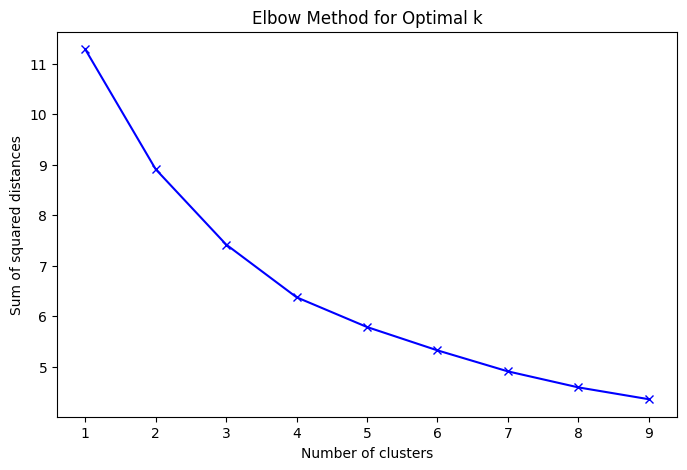

In [24]:
# Plotting the SSD for the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, ssd, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

##### Silhouette Scores

In [27]:
# Determine optimal number of clusters using Silhouette Score
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_features)
    score = silhouette_score(train_features, kmeans.labels_)
    silhouette_scores.append(score)

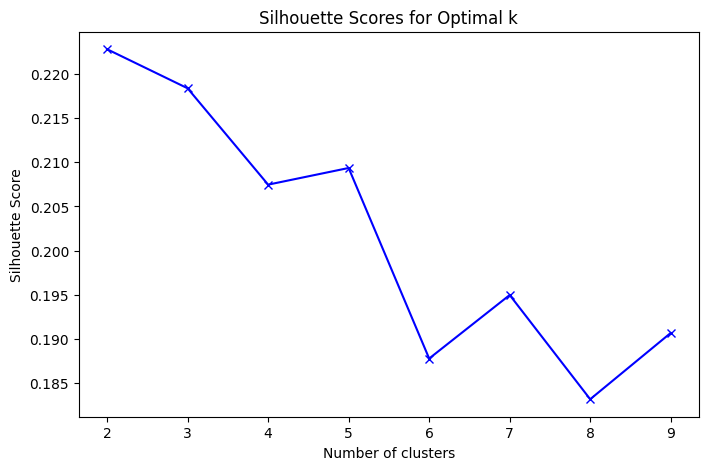

In [28]:
# Plotting the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal k')
plt.show()

Based on the elbow method and the silhouette scores plots provided:

**Elbow Method Plot:** The "elbow" point appears to be at k=3. This is where the sum of squared distances (SSD) starts to level off, indicating that adding more clusters beyond this point does not significantly reduce the SSD.
- The elbow method is a heuristic used to determine the optimal number of clusters in a dataset. It involves plotting the within-cluster sum of squares (WCSS) against the number of clusters. WCSS measures the compactness of the clusters. It is the sum of the squared distances between each point in a cluster and its centroid.
- To find the elbow point, you plot the WCSS for different numbers of clusters and look for the point where the rate of decrease sharply changes, resembling an "elbow" shape in the plot. This point represents the optimal number of clusters where adding more clusters does not significantly decrease the WCSS.

**Silhouette Score Plot:** The highest silhouette score is at k=2, but it decreases as the number of clusters increases. However, k=3 still maintains a relatively high silhouette score compared to higher values of k.
- The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to 1. A high silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
- The silhouette score for the entire clustering is calculated as the mean silhouette score of all samples.

As such, k=3 seems to be a good choice for the number of clusters. It balances both the elbow method's indication and maintains a reasonable silhouette score.

In [29]:
# Choosing the optimal number of clusters based on Elbow Method and Silhouette Scores
optimal_clusters = 3

Now, we will use the above information to apply clustering techniques onto our dataset. Clustering groups similar data points together, which can be particularly useful in unsupervised learning where labels are not provided.

In [30]:
# Perform KMeans clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
train_clusters_kmeans = kmeans.fit_predict(train_features)
train_new_df['cluster_kmeans'] = train_clusters_kmeans

In [32]:
train_ds_cluster_kmeans = BrainTumorMRIDataset(train_new_df, transform=train_transforms)

In [31]:
def compute_cluster_metrics(dataset):
    cluster_pixels = {}
    for image, _, cluster_label in dataset:
        pixels = image.cpu().numpy().flatten()
        pixels = pixels * 255   # Since tensors are normalized, we'll convert them back to a typical intensity scale if needed
        if cluster_label in cluster_pixels:
            cluster_pixels[cluster_label].extend(pixels)
        else:
            cluster_pixels[cluster_label] = list(pixels)

    cluster_metrics = {}
    for cluster, pixels in cluster_pixels.items():
        pixels = np.array(pixels)
        avg_intensity = np.mean(pixels)
        std_dev = np.std(pixels)
        cluster_metrics[cluster] = {'avg_intensity': avg_intensity, 'std_dev': std_dev}

    return cluster_metrics

In [33]:
kmeans_metrics = compute_cluster_metrics(train_ds_cluster_kmeans)
kmeans_metrics

{3: {'avg_intensity': 47.403687, 'std_dev': 41.16208},
 0: {'avg_intensity': 32.86749, 'std_dev': 39.523575},
 2: {'avg_intensity': 63.047462, 'std_dev': 63.520638},
 1: {'avg_intensity': 44.899525, 'std_dev': 49.508053}}

#### KMeans Cluster Metrics
- **Average Intensity (avg_intensity):** This is the mean pixel intensity of all images grouped into a specific cluster. In medical imaging, like MRI scans, this might reflect the overall brightness or contrast of the images which can be related to the tissue or anomaly characteristics in medical scenarios.
- **Standard Deviation (std_dev):** This represents the variability or spread of the pixel intensities within each cluster. A higher standard deviation indicates a wider range of pixel intensity values, suggesting more variability within the images of that cluster. Conversely, a lower standard deviation indicates more uniformity among the images in terms of brightness and contrast.

Specific Cluster Details:
- Cluster 3 has an average intensity of 47.40 with a standard deviation of 41.16, suggesting a moderate average intensity with a wide range of pixel values.
- Cluster 0 shows a lower average intensity of 32.87 with a standard deviation of 39.52, indicating less brightness but still a significant spread in intensity values.
- Cluster 2 exhibits the highest average intensity at 63.05 and also the highest variability (standard deviation of 63.52), which could mean this cluster contains the most distinct or varied images in terms of brightness.
- Cluster 1 has an average intensity of 44.90 with a standard deviation of 49.51, which is moderately high in both average intensity and variability.

## Training the Model

In [35]:
# Ensure DataLoader uses proper collate_fn to handle None values
def custom_collate_fn(batch):
    # Filter out None values in the batch
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

In [36]:
train_loader_cluster_kmeans = DataLoader(train_ds_cluster_kmeans, batch_size=CFG.BATCH_SIZE, shuffle=CFG.APPLY_SHUFFLE, num_workers=CFG.NUM_WORKERS, collate_fn=custom_collate_fn)

In [37]:
# Training the model with clustering labels
efficientnet_model = EfficientNetV2Model(backbone_model, num_classes=4, device=CFG.DEVICE)
optimizer = optim.AdamW(efficientnet_model.parameters(), lr=CFG.LR)
loss_fn = nn.CrossEntropyLoss()

In [39]:
def execute_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch_idx, (images, targets, clustering_labels) in enumerate(tqdm(dataloader)):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct = predicted.eq(targets).sum().item()
        train_acc += correct
    
    train_loss /= len(dataloader.dataset)
    train_acc /= len(dataloader.dataset)
    return train_loss, train_acc

In [40]:
def evaluate(model, dataloader, loss_fn, device) -> Tuple[float, float]:
    model.eval()
    eval_loss, eval_acc = 0, 0
    with torch.inference_mode():
        for batch_idx, batch in enumerate(dataloader):
            if batch is None:
                print(f"Batch {batch_idx} is None, skipping.")
                continue
            
            X, y, _ = batch
            if X is None or len(X) == 0:
                print(f"Batch {batch_idx} is empty, skipping.")
                continue
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()
            predicted_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    return eval_loss, eval_acc

In [42]:
def train(model, train_dataloader, eval_dataloader, optimizer, loss_fn, epochs, device):
    session = {'loss': [], 'accuracy': [], 'eval_loss': [], 'eval_accuracy': []}
    for epoch in range(epochs):
        train_loss, train_acc = execute_epoch(model, train_dataloader, optimizer, loss_fn, device)
        eval_loss, eval_acc = evaluate(model, eval_dataloader, loss_fn, device)
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuracy'].append(eval_acc)
    return session

In [43]:
efficientnet_session_config_cluster_kmeans = {
    'model': efficientnet_model,
    'train_dataloader': train_loader_cluster_kmeans,
    'eval_dataloader': val_loader,
    'optimizer': optimizer,
    'loss_fn': loss_fn,
    'epochs': CFG.EPOCHS,
    'device': CFG.DEVICE
}
efficientnet_session_history_cluster_kmeans = train(**efficientnet_session_config_cluster_kmeans)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

## Performance Analysis

In [44]:
def predict(model, dataloader, device):
    predictions = []
    model.eval()
    with torch.no_grad():
        for images, _, _ in tqdm(dataloader):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

In [45]:
def plot_training_curves(history):
    loss = np.array(history['loss'])
    accuracy = np.array(history['accuracy'])
    val_loss = np.array(history['eval_loss'])
    val_accuracy = np.array(history['eval_accuracy'])
    epochs = range(len(history['loss']))

    # Plot loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='eval_accuracy', marker='o')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();
    return

In [46]:
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]

In [48]:
efficientnet_test_preds_kmeans = predict(efficientnet_model, test_loader, CFG.DEVICE)
print(efficientnet_test_preds_kmeans)

  0%|          | 0/41 [00:00<?, ?it/s]

[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 3, 0, 0, 1, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 3, 0, 0, 1, 0, 0, 1, 0, 0, 3, 0, 0, 3, 1, 1, 1, 0, 0, 3, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 3, 3, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 3, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [59]:
efficientnet_kmeans_history_df = pd.DataFrame(efficientnet_session_history_cluster_kmeans)
efficientnet_kmeans_history_df

,loss,accuracy,eval_loss,eval_accuracy
0,1.066093,0.563596,0.887471,0.649671
1,0.663715,0.767544,0.700279,0.736020
2,0.581085,0.785088,0.571181,0.809211
3,0.479195,0.820175,0.449883,0.864309
4,0.469796,0.831140,0.403665,0.882401
5,0.403857,0.842105,0.373994,0.882401
6,0.371926,0.864035,0.422817,0.869243
7,0.396312,0.864035,0.410119,0.853618
8,0.399209,0.842105,0.402019,0.895559
9,0.298494,0.877193,0.423416,0.874589


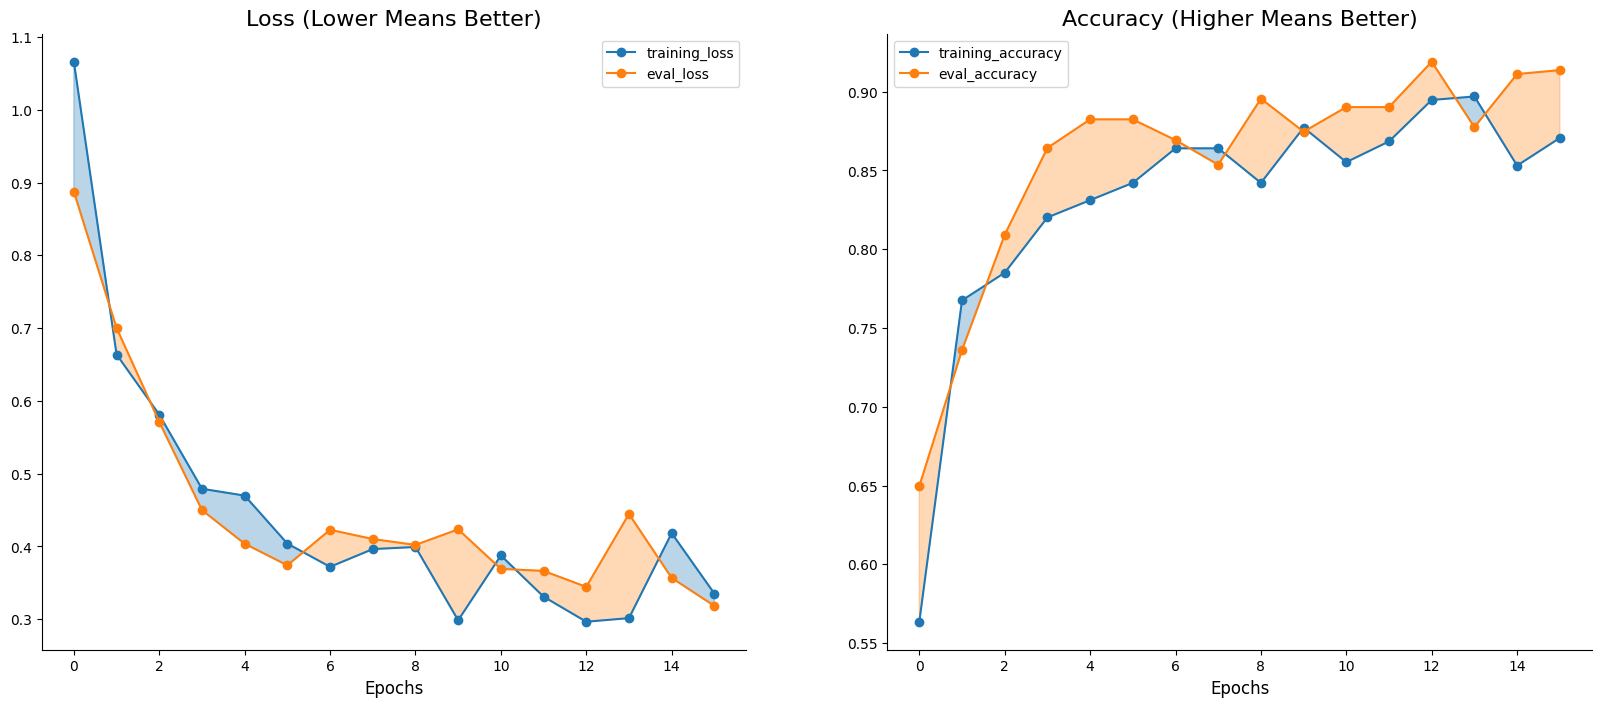

In [50]:
plot_training_curves(efficientnet_session_history_cluster_kmeans)

**Loss Graph**
- Training Loss (Blue line) shows a sharp decrease from the initial epoch, quickly stabilizing as epochs progress. This indicates that the model is effectively learning and optimizing its parameters from the training data.
- Evaluation Loss (Orange line) also decreases initially but shows some variability with minor fluctuations up and down as the epochs increase. This suggests that while the model performs well on training data, its performance on unseen validation data is slightly less stable.

**Accuracy Graph**
- Training Accuracy (Blue line) rapidly increases, indicating the model's good performance on the training dataset.
- Evaluation Accuracy (Orange line) rises significantly at the start but has notable fluctuations throughout the training process. This indicates variability in the model's generalization to new, unseen data.

The divergence between training and evaluation metrics suggests potential overfitting, where the model is too closely fitted to the training data, losing some ability to generalize effectively.

In [55]:
cm = confusion_matrix(test_labels, efficientnet_test_preds_kmeans)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[201  81   1  17]
 [  7 248  30  21]
 [  8   9 385   3]
 [  2  21   0 277]]


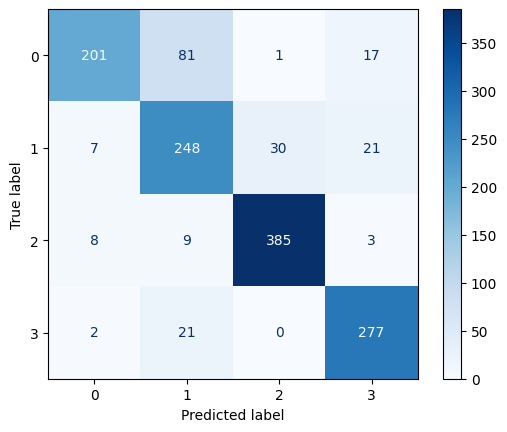

In [58]:
ConfusionMatrixDisplay.from_predictions(test_labels, efficientnet_test_preds_kmeans, cmap=plt.cm.Blues)
plt.show()

The confusion matrix shows the performance of a classifier with respect to the true labels versus predicted labels for different classes (glioma, meningioma, notumor, and pituitary).
Diagonal values represent correct predictions, whereas off-diagonal values indicate misclassifications. For example, gliomas are mostly correctly identified, but there are some confusions with meningiomas.
- Class 0 (glioma): The model correctly predicts 201 out of 300 cases, but there are significant misclassifications as Class 1.
- Class 1 (meningioma): Predicted quite well with 248 correct out of 306 cases, showing some confusion with Class 3.
- Class 2 (notumor): Very accurately predicted with 385 correct predictions out of 405 cases.
- Class 3 (pituitary): Also well predicted with 277 out of 300 cases, with some misclassifications as Class 1.

In [56]:
report = classification_report(test_labels, efficientnet_test_preds_kmeans)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.78       300
           1       0.69      0.81      0.75       306
           2       0.93      0.95      0.94       405
           3       0.87      0.92      0.90       300

    accuracy                           0.85      1311
   macro avg       0.85      0.84      0.84      1311
weighted avg       0.86      0.85      0.85      1311



- Precision: Indicates the model's accuracy in predicting positive instances. Class 2 has the highest precision (0.93), meaning it rarely mislabels other classes as Class 2.
- Recall: Measures the model's ability to identify all actual positives. Class 2 excels again (0.95), indicating it identifies most true Class 2 instances.
- F1-Score: A harmonic mean of precision and recall, giving a balance between the two. Class 2 has the highest F1-score (0.94), affirming it as the best-predicted class.
- Support: The number of true instances for each class in the dataset, which shows a balanced distribution across classes for this model's evaluation.

In [60]:
accuracy_score(test_labels, efficientnet_test_preds_kmeans)

0.84744469870328

Overall, the model shows robust performance, especially in identifying Class 2 (possibly a specific type of medical image or condition). However, there's a need to improve Class 0's recall and overall generalization, as indicated by fluctuations in evaluation accuracy and loss.

### Comparison with Original Model (in P2_supervised.ipynb)
**Confusion Matrix Analysis (Initial Model):**
- Glioma: Correctly predicted 233 out of 300 instances but with significant confusion with meningioma (54 cases).
- Meningioma: Correctly predicted 197 out of 300 instances, with notable misclassifications towards glioma (42 cases) and pituitary (47 cases).
- Notumor: Very well identified with 384 correct predictions out of 405 cases, showing high specificity.
- Pituitary: Correctly predicted 285 out of 300 cases with minimal confusion.

**Loss and Accuracy Graphs (Initial Model):**
- Loss: The training and evaluation loss both show a downward trend with some fluctuations, indicating a degree of model learning and generalization. However, there is a noticeable gap between training and evaluation loss suggesting some overfitting.
- Accuracy: Shows substantial fluctuations, especially in the evaluation accuracy, which suggests variability in model performance across different data sets or possible overfitting to the training data.

**Confusion Matrix Analysis (PCA/Clustering Model):**
- Class 0 (Glioma): Lower true positive rate compared to initial predictions of glioma.
- Class 1 (Meningioma): Improved identification compared to initial model, less confusion with other classes.
- Class 2 (Notumor): High accuracy similar to the initial model.
- Class 3 (Pituitary): Slightly improved performance compared to the initial model.

**Loss and Accuracy Graphs (PCA/Clustering Model):**
- Loss: There's a more consistent decline in evaluation loss, suggesting that the model after PCA/clustering is better at generalizing beyond training data.
- Accuracy: The accuracy, particularly evaluation accuracy, is more stable and higher on average after employing PCA/clustering, indicating improved model robustness and generalization.


##### **Overall Comparison and Assessment:**
Based on the confusion matrices, The initial model has good performance on notumor and pituitary predictions but struggles with glioma and meningioma due to high misclassification rates.
The PCA/clustering model shows a more balanced performance across all classes, with particularly improved clarity in distinguishing between meningioma and glioma. Additionally, the loss/accuracy plots show that the initial model displays higher variability and potential overfitting as indicated by the wider gaps between training and evaluation loss and accuracy. Meanwhile, the PCA/clustering model, on the other hand, shows more stability and consistency in both loss and accuracy, suggesting better handling of variance in the data and improved model generalization.

The use of PCA and clustering techniques appears to have enhanced the model's ability to generalize and reduced overfitting, evident from the more stable evaluation metrics. Additionally, the more balanced confusion matrix after PCA/clustering suggests that this approach may be better for practical applications where robustness across various classes is crucial. This makes the PCA/clustering model a better choice for settings where generalization and accuracy across diverse scenarios are paramount.